In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

# Load Data

In [42]:
df = pd.read_csv("GME.csv")
final_data = df
final_data.head()

,timestamp,open,high,low,close,volume,change
0,2022-04-29,127.30,130.8900,123.0100,125.07,1285855,-2.23
1,2022-04-28,130.28,132.6034,120.5000,129.31,1771223,-0.97
2,2022-04-27,127.27,132.6800,124.5840,129.84,1305874,2.57
3,2022-04-26,135.64,136.8000,126.1637,127.60,1533908,-8.04
4,2022-04-25,135.41,139.7100,133.2841,135.95,1534779,0.54


# Visualize Data

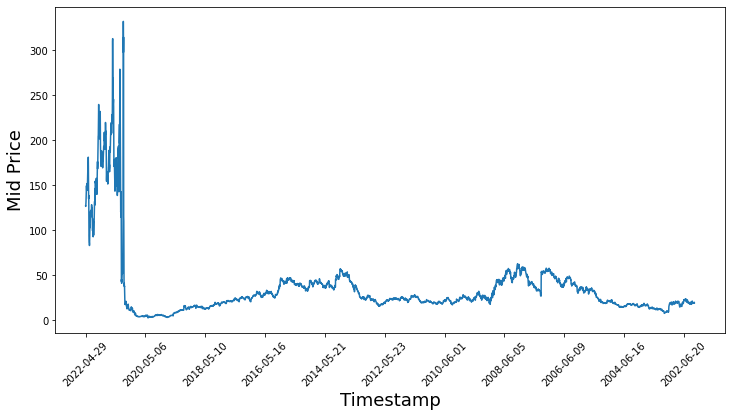

In [43]:
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['timestamp'].loc[::500],rotation=45)
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Data Preprocessing

In [44]:
# 1. Filter out the closing market price data
close_data = final_data.filter(['close'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 70% of the data
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


# Build the LSTM Model

In [45]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

## Compile the Model

In [46]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

3503/3503 [==============================] - 50s 14ms/step - loss: 0.0019


# Test the Model

In [47]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
# 2. Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## RMSE

In [48]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

1.5300682608451606


/var/folders/60/119q0_pn0fzgzlht5v1c51h00000gn/T/ipykernel_60368/2074149537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


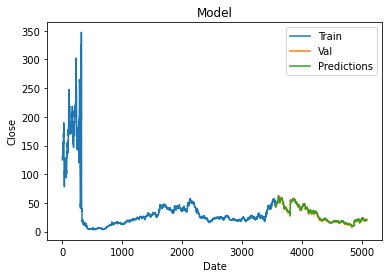

<Figure size 432x288 with 0 Axes>

In [49]:
training_data_len = math.ceil(len(dataset) *.7)

train = final_data[:training_data_len]
valid = final_data[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()
plt.savefig("amdPrediction.png")